Image colorization project :
We train a CNN to take in greyscale images of ... and output their colorful and plausible colorization.

Imports required :

torch

skimage ? only used for rgb - lab parsing. Maybe we can do that ourselves to make some differentiation with the original project?

numpy

matplotlib

PIL ? only used to open images to rgb. We can use another library

In [40]:
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
from skimage import color
from scipy.ndimage import gaussian_filter

import os
import os.path

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

import pickle
import json

## Load data, augment it, transform it to LAB compute stats on colors

dataset =  Dataset CustomImageDataset
    Number of datapoints: 3829
    Root location: cat_dataset/training_set
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               PILToTensor()
           )


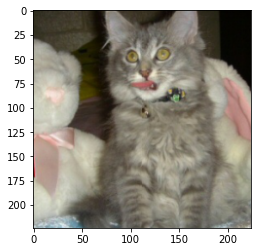

torch.Size([3, 224, 224])


In [63]:
#Data loading
from torchvision import datasets, transforms, utils
from torchvision.datasets import folder, ImageFolder

transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.PILToTensor(),
])

class CustomImageDataset(ImageFolder):
    def __init__(self,root, transform = None,):
        super().__init__(root,transform=transform)

    def __len__(self):
        return super().__len__()

    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, index

dataset = CustomImageDataset("cat_dataset/training_set",transform=transform)
batch_size = 32
loader = data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
print("dataset = ",dataset)
images, indexes = next(iter(loader))


img = images[0]
plt.imshow(transforms.functional.to_pil_image(img))
plt.show()
print(img.shape)
img2 = img.numpy()


#for i, (images, labels) in enumerate(loader, 0):
   #print(images.size())
    #sample_fname, _ = loader.dataset.samples[i]
   # print(sample_fname)


(224, 224, 3)
[[[ 9.62776730e+01  3.34122272e+00  2.28269412e+00]
  [ 9.62776730e+01  3.34122272e+00  2.28269412e+00]
  [ 9.62776730e+01  3.34122272e+00  2.28269412e+00]
  ...
  [ 7.98869242e+01  4.72329156e+00  2.26967472e+00]
  [ 7.98869242e+01  4.72329156e+00  2.26967472e+00]
  [ 7.91630869e+01  4.73296880e+00  2.27456044e+00]]

 [[ 9.62776730e+01  3.34122272e+00  2.28269412e+00]
  [ 9.62776730e+01  3.34122272e+00  2.28269412e+00]
  [ 9.62776730e+01  3.34122272e+00  2.28269412e+00]
  ...
  [ 7.98869242e+01  4.72329156e+00  2.26967472e+00]
  [ 7.95251760e+01  4.72811556e+00  2.27210972e+00]
  [ 7.91630869e+01  4.73296880e+00  2.27456044e+00]]

 [[ 9.62776730e+01  3.34122272e+00  2.28269412e+00]
  [ 9.62776730e+01  3.34122272e+00  2.28269412e+00]
  [ 9.62776730e+01  3.34122272e+00  2.28269412e+00]
  ...
  [ 7.95251760e+01  4.72811556e+00  2.27210972e+00]
  [ 7.95251760e+01  4.72811556e+00  2.27210972e+00]
  [ 7.91630869e+01  4.73296880e+00  2.27456044e+00]]

 ...

 [[ 1.00000000e+02 -

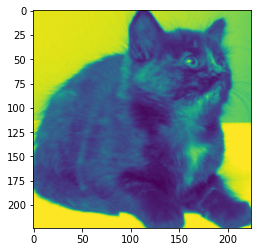

In [3]:
#LAB transform

def rgb2lab(img):
    #INPUT  RGB image of shape (...,3,H,W)
    #OUTPUT LAB image of shape (...,H,W,3) 

    lab_imgs = color.rgb2lab(img,channel_axis = 0)
    return np.transpose(lab_imgs,(1,2,0))

print(rgb2lab(img2).shape) 
print(rgb2lab(img2)) 

def separateChannels(imageLAB):
    #Input : LAB image with format (H,W,3)
    l = imageLAB[:,:,0]
    a = imageLAB[:,:,1]
    b = imageLAB[:,:,2]
    return l,a,b

l,a,b = separateChannels(rgb2lab(img2))
plt.imshow(l)
plt.show()



### Color stats

In [4]:
#Color stats (auxiliary functions)

def getDiscretisedColor(a,b,gridSize):
    a = np.round(a/gridSize) * gridSize
    b = np.round(b/gridSize) * gridSize
    return (a,b)

def getMatrixIndex(a,b,gridSize):
    i = (a + 500) / gridSize
    j = (b + 200) / gridSize
    return (int(i),int(j))

def getColorValue(i,j,gridSize):
    a = i * gridSize - 500
    b = j * gridSize - 200
    return (a,b)

def getNNearestNeigbhors(a,b,gridSize): # to improve "getColorDistribution"
    # ... to do
    #return list of (a,b)
    return
    

In [5]:
#Color stats

# need dataset express like that: list of images (as tensor) with dim H x W x 2 ...
#image_test = rgb2lab(img2) # need to change dim order of color stat code... ?
#images = [np.random.rand(3,3,2) * 100]
#images = [image_test[:][:][1:2]]
#print(image_test.shape)
#print(images[0])

# Initialise the proba distribution of ab pairs in the images dataset (discretised).
gridSize = 10 # too big ?
colorProbabilities = np.zeros((1000 // gridSize, 400 // gridSize))

# Compute the proba distribution of the ab pairs in the images dataset (discretised).
nbOfAnalysedPixels = 0
for data in loader:
    images,_ = data
    for image in images: 
        image = image.numpy()
        image = rgb2lab(image)[:][:][1:2]
        for h in range (image.shape[0]):
            for w in range (image.shape[1]):
                (a,b) = getDiscretisedColor(image[h][w][0],image[h][w][1],gridSize)
                (i,j) = getMatrixIndex(a,b,gridSize)
                colorProbabilities[i][j] += 1
                nbOfAnalysedPixels += 1
colorProbabilities = colorProbabilities / nbOfAnalysedPixels



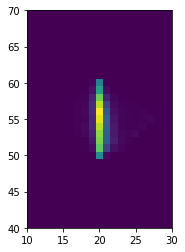

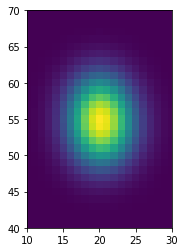

203
[(-40, -10), (-40, 0), (-40, 10), (-30, -30), (-30, -20), (-30, -10), (-30, 0), (-30, 10), (-30, 20), (-30, 30), (-20, -40), (-20, -30), (-20, -20), (-20, -10), (-20, 0), (-20, 10), (-20, 20), (-20, 30), (-20, 40), (-10, -50), (-10, -40), (-10, -30), (-10, -20), (-10, -10), (-10, 0), (-10, 10), (-10, 20), (-10, 30), (-10, 40), (-10, 50), (0, -50), (0, -40), (0, -30), (0, -20), (0, -10), (0, 0), (0, 10), (0, 20), (0, 30), (0, 40), (0, 50), (0, 60), (10, -60), (10, -50), (10, -40), (10, -30), (10, -20), (10, -10), (10, 0), (10, 10), (10, 20), (10, 30), (10, 40), (10, 50), (10, 60), (20, -60), (20, -50), (20, -40), (20, -30), (20, -20), (20, -10), (20, 0), (20, 10), (20, 20), (20, 30), (20, 40), (20, 50), (20, 60), (20, 70), (30, -60), (30, -50), (30, -40), (30, -30), (30, -20), (30, -10), (30, 0), (30, 10), (30, 20), (30, 30), (30, 40), (30, 50), (30, 60), (30, 70), (40, -60), (40, -50), (40, -40), (40, -30), (40, -20), (40, -10), (40, 0), (40, 10), (40, 20), (40, 30), (40, 40), (40,

In [6]:
# + display distribution in 2d plot ? like in paper (here, very simple)
plt.imshow(colorProbabilities, interpolation='none')
plt.xlim(10, 30) # need to be dynamic !
plt.ylim(40, 70)
plt.show()

# Smooth the proba distribution of the ab pairs in the images dataset.
sigma = 3 # gaussian kernel parameter (test with 1 and no treshold ?)
colorProbabilities_smooth = gaussian_filter(colorProbabilities, sigma=sigma) # is it ok ? add a lot of value in gamut... take proba treshold ?
treshold = 0.001 # add treshold if smoothing

# + display distribution in 2d plot ? like in paper (here, very simple)
plt.imshow(colorProbabilities_smooth, interpolation='none')
plt.xlim(10, 30) # need to be dynamic !
plt.ylim(40, 70)
plt.show()

# Get the vector of proba of ab pairs that are "in gamut"
inGamutColors = []
inGamutColorsProbas = []
inGamutIndex = {}
currentColorIndex = 0
for i in range (colorProbabilities_smooth.shape[0]):
    for j in range (colorProbabilities_smooth.shape[1]):
        currentColorPorba = colorProbabilities_smooth[i][j]
        if currentColorPorba > treshold: # put a treshold ? if we use smoothing 
            (a,b) = getColorValue(i,j,gridSize)
            inGamutColors.append((a,b))
            inGamutColorsProbas.append(currentColorPorba)
            inGamutIndex[(a,b)] = currentColorIndex
            currentColorIndex += 1
        
Q = len(inGamutColors) 
p_smooth = torch.tensor(inGamutColorsProbas) # + need to normalise ? because treshold
print(Q)
print(inGamutColors)
print(inGamutColorsProbas)
print(inGamutIndex)
#Q = 1 # to remove

### Class rebalancing

In [7]:
#Define pixel weight vector (class rebalancing)

# Set the parameters (from paper, need empirical value).
lambda_uniform = 1/2 

# Compute a smooth version of the empirical pixel color distribution.
#p_smooth = p # how to do that ? gaussian kernel ? done at previous cell...

# Compute the weight vector.
pixelsWeights = torch.reciprocal((1 - lambda_uniform) * p_smooth + lambda_uniform / Q)

# Normalise the weight vector according to p_smooth (E[W] = 1).
E_W = torch.sum(p_smooth * pixelsWeights)
scale_factor = 1 / E_W
pixelsWeights = scale_factor * pixelsWeights 

print(pixelsWeights)

tensor([1.9303, 1.9039, 1.9143, 1.8998, 1.7868, 1.7058, 1.6696, 1.6832, 1.7443,
        1.8432, 1.8706, 1.7046, 1.5622, 1.4643, 1.4213, 1.4366, 1.5085, 1.6297,
        1.7842, 1.9087, 1.7045, 1.5064, 1.3457, 1.2397, 1.1941, 1.2098, 1.2858,
        1.4186, 1.5968, 1.7965, 1.7834, 1.5456, 1.3280, 1.1602, 1.0535, 1.0085,
        1.0236, 1.0988, 1.2341, 1.4238, 1.6483, 1.8724, 1.9173, 1.6688, 1.4086,
        1.1824, 1.0152, 0.9119, 0.8690, 0.8834, 0.9556, 1.0882, 1.2807, 1.5188,
        1.7686, 1.8463, 1.5742, 1.3015, 1.0737, 0.9105, 0.8119, 0.7715, 0.7855,
        0.8545, 0.9830, 1.1739, 1.4180, 1.6840, 1.9253, 1.7921, 1.5052, 1.2266,
        1.0004, 0.8418, 0.7475, 0.7095, 0.7234, 0.7902, 0.9154, 1.1041, 1.3504,
        1.6256, 1.8815, 1.7584, 1.4639, 1.1835, 0.9596, 0.8046, 0.7133, 0.6771,
        0.6915, 0.7576, 0.8815, 1.0694, 1.3169, 1.5967, 1.8598, 1.7471, 1.4513,
        1.1714, 0.9491, 0.7959, 0.7061, 0.6711, 0.6865, 0.7535, 0.8785, 1.0678,
        1.3170, 1.5982, 1.8618, 1.7593, 

## Define and instantiate Convolutional NN consistent with the description of the paper. Shown in table 4.

In [8]:
#NN def

class ColorizationCNN(nn.Module):
    def __init__(self, nb_colour_bins = 313):
        super().__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.
        
        channels_block_1 = 64
        channels_block_2 = 128
        channels_block_3 = 256
        channels_block_4 = 512
        channels_block_5 = 512 #dilated
        channels_block_6 = 512 #dilated
        channels_block_7 = 512 
        channels_block_8 = 128 # transpose convolution necessary

        # first conv block : 2 convs. from luminosity image to 64 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock1 = nn.Sequential(nn.Conv2d(1,channels_block_1,(3,3), padding =1), 
                nn.ReLU(True), #inplace for memory efficiency can be used as no skip connections are used.
                nn.Conv2d(channels_block_1,channels_block_1,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_1) #normalization over the 64 channels created
        )

        # second conv block. 2 covs. from 64 features to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock2 = nn.Sequential(nn.Conv2d(64,channels_block_2,(3,3), padding =1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_2,channels_block_2,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_2)
        )

        # third conv block. 3 convs. from 64 to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock3 = nn.Sequential(nn.Conv2d(channels_block_2,channels_block_3,(3,3), padding = 1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_3)
        )

        # fourth conv block. 3 convs. from 256 to 512 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock4 = nn.Sequential(nn.Conv2d(channels_block_3,channels_block_4,(3,3), padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_4)
        )
        
        #fifth conv block. 3 convs. no change in nb feature maps. 3x3 kernels with 2 dilation and 2 padding to not downscale. normalization at the end.

        self.convBlock5 = nn.Sequential(nn.Conv2d(channels_block_4,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_5)
        )

        #sixth conv block. same as 5
        self.convBlock6 = nn.Sequential(nn.Conv2d(channels_block_5,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_6)
        )

        #seventh conv block : 3 convs with 3x3 kernels.
        self.convBlock7 = nn.Sequential(nn.Conv2d(channels_block_6,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_7)
        )

        #eighth conv block : 1 inverse conv to upsample then 2 convs with 3x3 kernels default parameters. Final convolution with 1x1 for classification into a colour bin
        self.convBlock8 = nn.Sequential(nn.ConvTranspose2d(channels_block_7,channels_block_8,(4,4),stride = 2, padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,nb_colour_bins,kernel_size=1) #1x1 kernel for classification in each colour bin (value will be soft maxed for probability)
        )

        self.outputLayer = nn.Conv2d(nb_colour_bins,2,kernel_size=1,dilation=1, bias = False) # 1x1 kernel to get 2 channel values of a and b respectively
    
    def forward(self, luminosity_image):
        h1 = self.convBlock1((luminosity_image-self.l_cent)/self.l_norm) #normalize luminosity to be on scale of 0 to 100
        h2 = self.convBlock2(h1)
        h3 = self.convBlock3(h2)
        h4 = self.convBlock4(h3)
        h5 = self.convBlock5(h4)
        h6 = self.convBlock6(h5)
        h7 = self.convBlock7(h6)
        h8 = self.convBlock8(h7)

        colour_bin_proba = (nn.Softmax(dim=1))(h8)
        '''
        output = self.outputLayer(colour_bin_proba)
        upscaled_output = (nn.Upsample(scale_factor=4, mode='bilinear'))(output) # bilinear upscale to agree with input image size 
        upscaled_output * self.ab_norm # denormalize to cover whole ab value range
        '''
        return colour_bin_proba
        
        

## Define Loss

### Soft encoding

In [9]:
#Convert a true image Y[BxHxWx2] to pixels color distributions Z[BxHxWxQ] (soft encoding)

# Define a distance measure bewteen two colors (a,b).
colorDistance = lambda c1, c2: np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)


# Define a Gaussian kernel.
def gaussianKernel(distances):
    sigma = 5
    weights = np.exp(-(distances**2) / sigma)
    return weights


def getColorDistribution(Y,nbOfNeighbors):
    # Initiate a tensor to store the distributions produced from Y.
    Z = torch.zeros(Y.shape[0], Y.shape[1], Y.shape[2], Q)

    # Produce a color distribution for each pixel of the image.
    for i in range (Z.shape[0]):
        print(i)
        for h in range (Z.shape[1]):
            for w in range (Z.shape[2]):
                color_true = Y[i][h][w]
                distances = np.array([colorDistance(color,color_true) for color in inGamutColors]) # not efficient... possible to do better ?
                nearestNeighborsIndexs = (-distances).argsort()[:nbOfNeighbors]
                #nearestNeighborsIndexs = np.argpartition(distances, -nbOfNeighbors)[-nbOfNeighbors:]
                weights = torch.from_numpy(gaussianKernel(distances[nearestNeighborsIndexs]))
                for j in range (weights.shape[0]):
                    Z[i][h][w][nearestNeighborsIndexs[j]] = weights[j]
    
    # Return the produced distributions.
    return Z
    

def getColorDistribution_1hot(Y):
    # Initiate a tensor to store the distributions produced from Y.
    Z = torch.zeros(Y.shape[0], Y.shape[1], Y.shape[2], Q)

    # Produce a color distribution for each pixel of the image.
    for i in range (Z.shape[0]):
        for h in range (Z.shape[1]):
            for w in range (Z.shape[2]):
                color_true = Y[i,h,w]
                a, b = getDiscretisedColor(color_true[0],color_true[1],gridSize)
                if (int(a),int(b)) in inGamutIndex:
                    gamutIndex = inGamutIndex[(int(a),int(b))] # bug, not always in gamut... due to pooling of Y ?
                    Z[i,h,w,gamutIndex] = 1
                else:
                    Z[i,h,w,:] = Z[i,h,w,:] + 1/Q
                    print("not in gamut")
                    #print(Z[i,h,w,:])
    
    # Return the produced distributions.
    return Z


### Point estimate

In [10]:
#Convert the pixel color distributions in Z[HxWxQ] to true picture estimate Y[HxWx2] (point estimate)

# No need to be very efficient because only use when we predict (after training) ? difficult to rewrite with tensor operation

def getPictureEstimate(Z,T):
    # Initiate a tensor to store the image estimated from Z.
    Y_estimate = torch.zeros(Z.shape[0], Z.shape[1], 2)
    
    # Estimate the Lab color for each pixel of the image.
    for h in range (Y_estimate.shape[0]):
        for w in range (Y_estimate.shape[1]):
            # Re-ajust the temperture of the current distribution.
            reajustedDistribution = torch.exp(torch.log10(Z[h,w,:]) / T)  / torch.sum(torch.exp(torch.log10(Z[h,w,:]) / T)) # check again...

            # Compute the anneled-mean of the current distribution. 
            a, b = 0, 0
            for q in range (Z.shape[2]):
                a += reajustedDistribution[q] * inGamutColors[q][0]
                b += reajustedDistribution[q] * inGamutColors[q][1]
            
            # Estimate the Lab color for the current pixel.
            Y_estimate[h][w][0] = a
            Y_estimate[h][w][1] = b
    
    # Return the estimated picture.
    return Y_estimate

### Loss function

In [11]:
# Take Z[BxHxWxQ] as input where B is the batch size

#v(Z_hw) weight in paper (section 2)

def getPixelsWeights(Z_batch):
    W = torch.argmax(Z_batch, dim=3)
    for i in range(W.size(dim=0)):
        for h in range(W.size(dim=1)):
            for w in range(W.size(dim=2)):
                W[i,h,w] = pixelsWeights[W[i,h,w]]

    return W

In [12]:
# Take Z[BxHxWxQ] as input where B is the batch size

#loss function 

def multinomialCrossEntropyLoss(Z_estimate_batch, Z_batch):
    W = getPixelsWeights(Z_batch)
    L = - torch.sum(torch.sum(torch.sum(W * torch.sum(Z_batch * torch.log10(Z_estimate_batch + sys.float_info.epsilon), dim=3), dim=2), dim=1))

    return L

#Loss = multinomialCrossEntropyLoss(torch.rand(4,224,224,Q), torch.rand(4,224,224,Q)) # test
#print(Loss)

## Main training loop and additional function TBD

### Soft encoding (pre computation of the distributions)

In [13]:
soft_encoded_images = {}

for data in loader:
    images, indexes = data

    #print(indexes.shape[0])

    lab_images = []

    for i in range(images.shape[0]):
        lab_im = rgb2lab(images[i].numpy())
        lab_images.append(lab_im)

    lab_images = torch.tensor(np.array(lab_images))

    downsampler_to_quarter_size = nn.AvgPool2d(4, stride=4)
    downsampled_lab = downsampler_to_quarter_size(torch.permute(lab_images,(0,3,1,2)))
    downsampled_lab = torch.permute(downsampled_lab,(0,2,3,1))

    #print(downsampled_lab[:,:,:,1:3].shape)
        
    imagesDistributions = getColorDistribution_1hot(downsampled_lab[:,:,:,1:3])

    for i in range(indexes.shape[0]):
        soft_encoded_images[indexes[i].item()] = imagesDistributions[i][:][:][:].numpy()
        
    

        

not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut
not in gamut

In [14]:
#soft_encoded_images[265]

#a_file = open("soft_encoded_images_1hot_cat2.pkl", "wb")
#pickle.dump(soft_encoded_images, a_file)
#a_file.close()

#a_file = open("soft_encoded_images_1hot_cat2.pkl", "rb")
#soft_encoded_images = pickle.load(a_file)
#print(output)
#a_file.close()



#a_file = open("soft_encoded_images_1hot_cat2.json", "w")
#json.dump(soft_encoded_images, a_file)
#a_file.close()


#a_file = open("soft_encoded_images_1hot_cat2.json", "r")
#output = a_file.read()


Define a training step: for each image in a batch : prediction, loss, backprop loss

In [25]:
def training_step(optim,loss_fct,network,dataloader):
    '''
        Function to execute a single training step
            Input : 
                optim = pytorch optimize used for the training step
                loss_fct = loss function used to compare the predicted output to ground truth
                dataloader = pytorch data loader to provide the training data used in the training step

            Output :
                average loss over the training step

    '''
    iteration_losses = []
    analysed_images = 0

    for data in dataloader:
        images, indexes = data

        lab_images_distributions = []
        l_images = []

        for i in range(images.shape[0]):
            lab_im = rgb2lab(images[i].numpy())
            lab_images_distributions.append(soft_encoded_images[indexes[i].item()]) # get pre-computed distributions (soft encoding)
            #print(soft_encoded_images[indexes[i].item()].shape)
            l_images.append(lab_im[:,:,0])
       

        lab_images_distributions = torch.tensor(np.array(lab_images_distributions)).to("cuda")
        #print(lab_images_distributions.shape)

        l_images = torch.tensor(np.array(l_images))
        l_images = torch.unsqueeze(l_images,dim=1).to("cuda")

        predicted_colour_probability = network.forward(l_images.float().to("cuda"))
        predicted_colour_probability = torch.permute(predicted_colour_probability,(0,3,2,1))
        
        loss = loss_fct(predicted_colour_probability, lab_images_distributions)
        iteration_losses.append(loss.item())

        optim.zero_grad() 
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(network.parameters(),10) # clip gradients to 10
        optim.step()
        
        analysed_images += batch_size
        print(f"fraction of the dataset analysed: {round(analysed_images/3829 * 100, 2)}%")

    return sum(iteration_losses) / len(iteration_losses) # average loss of training iteration

In [69]:
#colCNN = ColorizationCNN(nb_colour_bins = Q).to("cuda")

# to retrain a trained model
PATH = os.getcwd() + "/network_cat_100_epochs_4_3.pth"
network = ColorizationCNN(nb_colour_bins = Q)
network.load_state_dict(torch.load(PATH))
network.eval()
colCNN = network.to("cuda")
#initial_lr = 3e-5 Put current learning rate ? save it

initial_lr = 0.0001
optimizer = torch.optim.Adam(colCNN.parameters(),lr = initial_lr , weight_decay=0)
#loss_plateau_scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold = 20, factor = 0.3, verbose=True, patience= 2)
#loss_plateau_scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold = 2,  factor = 0.3, verbose=True, patience = 2)
nb_epochs = 30
losses = np.zeros(nb_epochs)

for epoch in range(nb_epochs):
    print('epoch :',epoch)
    losses[epoch] = training_step(optimizer,multinomialCrossEntropyLoss,colCNN,loader)
    print('current loss :',losses)
    #if nb_epochs in {10,20,30,40,50,60,70,80,90,100}:
        #print("network saved")
        #PATH = os.getcwd() + f"/network_cat_{nb_epochs}_epochs_1.pth"
        #torch.save(colCNN.to('cpu').state_dict(), PATH) 
    #loss_plateau_scheduler1.step(losses[epoch])
    #loss_plateau_scheduler2.step(losses[epoch])

epoch : 0
fraction of the dataset analysed: 0.84%
fraction of the dataset analysed: 1.67%
fraction of the dataset analysed: 2.51%
fraction of the dataset analysed: 3.34%
fraction of the dataset analysed: 4.18%
fraction of the dataset analysed: 5.01%
fraction of the dataset analysed: 5.85%
fraction of the dataset analysed: 6.69%
fraction of the dataset analysed: 7.52%
fraction of the dataset analysed: 8.36%
fraction of the dataset analysed: 9.19%
fraction of the dataset analysed: 10.03%
fraction of the dataset analysed: 10.86%
fraction of the dataset analysed: 11.7%
fraction of the dataset analysed: 12.54%
fraction of the dataset analysed: 13.37%
fraction of the dataset analysed: 14.21%
fraction of the dataset analysed: 15.04%
fraction of the dataset analysed: 15.88%
fraction of the dataset analysed: 16.71%
fraction of the dataset analysed: 17.55%
fraction of the dataset analysed: 18.39%
fraction of the dataset analysed: 19.22%
fraction of the dataset analysed: 20.06%
fraction of the da

Plot losses

In [34]:

#del iteration_losses
#learn.destroy() 
#torch.cuda.empty_cache()

#del colCNN


[41399.53181966 39328.01105143 37910.80113932 36703.84072266
 35591.55758464 34562.16321615 33845.62635091 32878.93821615
 31838.24560547 30979.11360677 30132.19482422 29355.42911784
 28645.84597982 28013.73204753 27258.69205729 26525.13854167
 26080.20646159 25697.09316406 24990.82750651 24478.30818685
 23913.17114258 23590.73916016 22796.37157389 22394.54726562
 22202.75438639 21732.13532715 21263.52696126 20803.80828451
 20537.92703451 20218.08628743 19662.33267415 19308.37285156
 19077.41974284 18815.43061523 18515.57627767 18321.58497721
 18255.83783366 18051.08092448 17616.18653971 17315.96066081
 17042.43725586 16933.93890788 16612.2267334  16231.99694824
 15920.14764811 15764.53597819 15789.13213704 15678.92716471
 15457.65901693 15176.34157715 15186.51732585 15100.40015462
 14798.8755778  14589.73163249 14438.51653239]


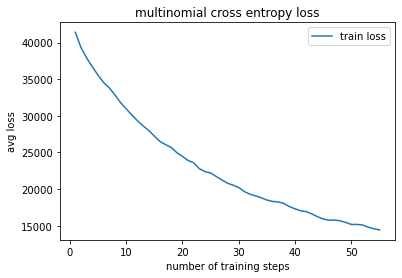

0.0001


-0.00997

In [53]:
print(losses)

x_axis = range(1,nb_epochs+1)
plt.plot(x_axis,losses, label="train loss")

plt.xlabel('number of training steps')
plt.ylabel('avg loss')
plt.title('multinomial cross entropy loss')
plt.legend()
plt.show()

for p in optimizer.param_groups:
    print(p["lr"])

3e-5 - 10 * 1e-3

Show the neural network colorization of a specific image vs the real colors of that image

In [46]:
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

def show_col_vs_truth(network,data_loader,batch_size):
    '''
        Function to output figure with one batch of colored images vs its ground truth
        Inputs: 
            -network : Neural network for a*b* channel value predictions
            -data_loader : pytorch data loader to load a batch of images

        Outputs:
            - Figure of colored images vs ground truth
    '''
    with torch.no_grad():
        
        # Load RGB images.
        images, indexes = next(iter(data_loader))

        show_images(utils.make_grid(images,nrow=batch_size))

        # Get l channel from RGB images.
        l_images = []
        for i in range(batch_size):
            lab_im = rgb2lab(images[i].numpy())
            l_images.append(lab_im[:,:,0])

        # Get a tensor of shape (Batch,1,H,W) out of the l images.
        l_images = torch.tensor(np.array(l_images))
        l_images = torch.unsqueeze(l_images,dim=1)

        # Predictinng the colour bin probability yields tensor of size (B,Q,H,W).
        predicted_colour_probability = network.forward(l_images.float())

        # Permute prediction to get (B,H,W,Q) to later get colour estimate.
        predicted_colour_probability = torch.permute(predicted_colour_probability,(0,2,3,1)) # or (0,3,2,1) ? or it is the same ?

        predicted_rgb_images = []
        for i in range(batch_size):

            # Get estimate in formate (H,W,2). format (H,W,Q) required.
            estimate = getPictureEstimate(predicted_colour_probability[i,:,:,:], 0.38)
            
            # Permute estimate to get (2,H,W) format.
            estimate = torch.permute(estimate,(2,0,1))
            
            # Define upsampler.
            bilinear_upsampler_to_224 = torch.nn.Upsample((224,224),mode='bilinear',align_corners=True)

            # Upsample. to get (2,224,224) format
            estimate = bilinear_upsampler_to_224(torch.unsqueeze(estimate, dim=0))[0,:,:,:]
            
            # Artificial modification, to solve issue.
            estimate = torch.permute(estimate,(0,2,1))

            # Fuse predicted channels and light channel. 
            predicted_lab_image = torch.cat((l_images[i,:,:,:],estimate), dim = 0)
            #permute to get (224,224,3)
            predicted_lab_image = predicted_lab_image.permute(1,2,0)

            # Convert to RGB and add to list. in format(3,224,224)
            predicted_rgb_images.append(color.lab2rgb(predicted_lab_image).transpose(2,0,1)) 
            
        # Transform list to tensor.
        predicted_rgb_images = torch.tensor(np.asarray(predicted_rgb_images))

        #print(images.shape)
        #print(predicted_rgb_images.shape)
        
        show_images(utils.make_grid(images,nrow=batch_size))
        show_images(utils.make_grid(predicted_rgb_images,nrow=batch_size))

        # Concatenate all images with ground truth first, then predictions.
        #images = torch.cat((images,predicted_rgb_images),dim=0) # don't seems to work

        # Show grid of images.
        #show_images(utils.make_grid(images,nrow=batch_size))


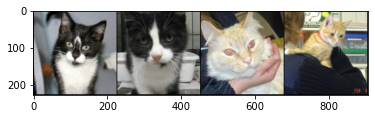

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


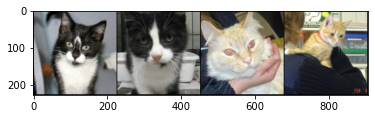

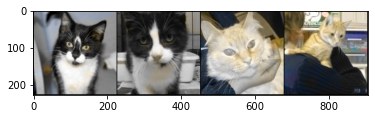

In [68]:
PATH = os.getcwd() + "/network_cat_130_epochs_4_4.pth"
#torch.save(colCNN.to('cpu').state_dict(), PATH)   #to save a network

# Load the network from file
#network = ColorizationCNN(nb_colour_bins = Q)
#network.load_state_dict(torch.load(PATH))
#network.eval()

#network = colCNN.to('cpu')

dataset_for_test = CustomImageDataset("cat_dataset/training_set",transform=transform)
loader_for_test = data.DataLoader(dataset, batch_size = 4, shuffle = True)

dataset_for_test_new = CustomImageDataset("cat_dataset/testing_set",transform=transform)
loader_for_test_new = data.DataLoader(dataset_for_test_new, batch_size = 4, shuffle = True)

show_col_vs_truth(network,loader_for_test, 4)

show_col_vs_truth(network,loader_for_test_new, 4)

In [ ]:
np.log10(sys.float_info.epsilon)
sys.float_info.epsilon

#torch.cuda.empty_cache()

#network = colCNN

for p in optimizer.param_groups:
    print(p["lr"])

#a_file = open("network_100.pkl", "wb")
#pickle.dump(network, a_file)
#a_file.close()


## Debugging 

In [ ]:
# Load RGB images.
#images, indexes = next(iter(loader))

#show_images(utils.make_grid(images,nrow=batch_size))

#lab_images_distributions = []
#for i in range(images.shape[0]):
  #  lab_images_distributions.append(soft_encoded_images[indexes[i].item()]) # get pre-computed distributions (soft encoding)
   # print(soft_encoded_images[indexes[i].item()].shape)



        
# Load RGB images.
images, indexes = next(iter(loader))

show_images(utils.make_grid(images,nrow=batch_size))

# Get l channel from RGB images.
l_images = []
predicted_rgb_images = []
for i in range(batch_size):
    lab_im = rgb2lab(images[i].numpy())
    l_images.append(lab_im[:,:,0])

    # Get a tensor of shape (Batch,1,H,W) out of the l images.
    l_images = torch.tensor(np.array(l_images))
    l_images = torch.unsqueeze(l_images,dim=1)
    
    # Estimate true image.
    soft_encoded_image = soft_encoded_images[indexes[i].item()]

    # Get estimate in formate (H,W,2). format (H,W,Q) required.
    estimate = getPictureEstimate(torch.tensor(soft_encoded_image), 0.38)
            
    # Permute estimate to get (2,H,W) format.
    estimate = torch.permute(estimate,(2,0,1))
            
    # Define upsampler.
    bilinear_upsampler_to_224 = torch.nn.Upsample((224,224),mode='bilinear',align_corners=True)

    # Upsample.
    estimate = bilinear_upsampler_to_224(torch.unsqueeze(estimate, dim=0))[0,:,:,:]

    # Fuse predicted channels and light channel.
    predicted_lab_image = torch.cat((l_images[i,:,:,:],estimate), dim = 0)
    predicted_lab_image = predicted_lab_image.permute(2,1,0)

    # Convert to RGB and add to list.
    predicted_rgb_images.append(color.lab2rgb(predicted_lab_image).transpose(2,1,0))


# Transform list to tensor.
predicted_rgb_images = torch.tensor(np.asarray(predicted_rgb_images))

print(images.shape)
print(predicted_rgb_images.shape)
        
show_images(utils.make_grid(images,nrow=batch_size))
    
show_images(utils.make_grid(predicted_rgb_images,nrow=batch_size))

    


    





